# EDRN Breast Density – U-Net Training Pipeline

End-to-end ML pipeline driven by **Croissant metadata** with live, authenticated DICOM downloads from LabCAS:

1. **Load metadata** via `mlcroissant` from `croissant_mini.json`
2. **EDA** – inspect records in a Pandas DataFrame
3. **DICOM download & visualisation** – stream DICOMs from LabCAS URLs
4. **PyTorch Dataset** – on-demand authenticated download Dataset
5. **Train/val/test split** – 3 / 1 / 1
6. **Simple U-Net** – encoder/decoder with skip connections
7. **Training loop** – Dice + BCE loss, plot metrics

> **Auth**: Set `LABCAS_USERNAME` and `LABCAS_PASSWORD` env vars before running.  
> The notebook obtains a JWT token automatically and streams DICOMs via `Authorization: Bearer` header.

> **Note**: With only 5 samples this is purely a pipeline test. The results are not meaningful. On the full 2437-pair dataset, you would expect good generalization.

## 0. Installs & imports

In [ ]:
# Uncomment to install dependencies in a fresh env
# !pip install mlcroissant pydicom torch torchvision matplotlib pandas scikit-learn tqdm requests

In [3]:
import io
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom
import requests
from requests.auth import HTTPBasicAuth

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import mlcroissant as mlc

print('PyTorch:', torch.__version__)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device :', DEVICE)

PyTorch: 2.8.0+cpu
Device : cpu


## 1. Load Croissant metadata

In [8]:
# ── paths ──────────────────────────────────────────────────────────────────
PROJECT_ROOT   = Path(".")          # run from edrn_croissant_new/
CROISSANT_PATH = PROJECT_ROOT / "outputs" / "croissant_mini.json"

assert CROISSANT_PATH.exists(), f"Missing: {CROISSANT_PATH}"

# ── load Croissant dataset ─────────────────────────────────────────────────
print("Loading Croissant metadata …")
dataset = mlc.Dataset(jsonld=str(CROISSANT_PATH))
print("Dataset name :", dataset.metadata.name)
print("Record sets  :", [rs.name for rs in dataset.metadata.record_sets])

Loading Croissant metadata …
Dataset name : EDRN_Breast_Density_Collection_2_Mini
Record sets  : ['mammograms']


## 2. Load all records → list → DataFrame

In [9]:
print("Iterating records …")
records = list(dataset.records(record_set="mammograms"))
print(f"Total records loaded: {len(records)}")
print("\nFirst record keys:", list(records[0].keys()))

Iterating records …
Total records loaded: 5

First record keys: ['mammograms/group', 'mammograms/patient_id', 'mammograms/view', 'mammograms/proc_url', 'mammograms/mask_url', 'mammograms/proc_name', 'mammograms/mask_name']


In [10]:
# Build a clean DataFrame – decode bytes if needed
def decode_value(v):
    if isinstance(v, bytes):
        return v.decode("utf-8")
    return v

rows = [{k: decode_value(v) for k, v in rec.items()} for rec in records]
df = pd.DataFrame(rows)

# Simplify column names (strip 'mammograms/' prefix)
df.columns = [c.split("/")[-1] for c in df.columns]
print(df.to_string())

  group patient_id  view                                                                                                                                              proc_url                                                                                                                                                mask_url              proc_name                mask_name
0  case      C0250   LCC   https://edrn-labcas.jpl.nasa.gov/data-access-api/download?id=Automated_Quantitative_Measures_of_Breast_Density_Data/C0250/PROC/C0250_MG_PRO_LCC.dcm   https://edrn-labcas.jpl.nasa.gov/data-access-api/download?id=Automated_Quantitative_Measures_of_Breast_Density_Data/C0250/MASK/C0250_MASK_PRO_LCC.dcm   C0250_MG_PRO_LCC.dcm   C0250_MASK_PRO_LCC.dcm
1  case      C0250  LMLO  https://edrn-labcas.jpl.nasa.gov/data-access-api/download?id=Automated_Quantitative_Measures_of_Breast_Density_Data/C0250/PROC/C0250_MG_PRO_LMLO.dcm  https://edrn-labcas.jpl.nasa.gov/data-access-api/download?id=Automated_Qua

## 3. Basic Exploratory Data Analysis

In [11]:
print("=" * 50)
print("DATASET SUMMARY")
print("=" * 50)
print(f"Total pairs   : {len(df)}")
print(f"\nGroup counts:")
print(df['group'].value_counts().to_string())
print(f"\nPatient IDs   : {sorted(df['patient_id'].unique())}")
print(f"\nView counts:")
print(df['view'].value_counts().to_string())
print(f"\nMissing values:")
print(df.isnull().sum().to_string())

DATASET SUMMARY
Total pairs   : 5

Group counts:
group
case    5

Patient IDs   : ['C0250', 'C0251']

View counts:
view
LCC     2
LMLO    1
RCC     1
RMLO    1

Missing values:
group         0
patient_id    0
view          0
proc_url      0
mask_url      0
proc_name     0
mask_name     0


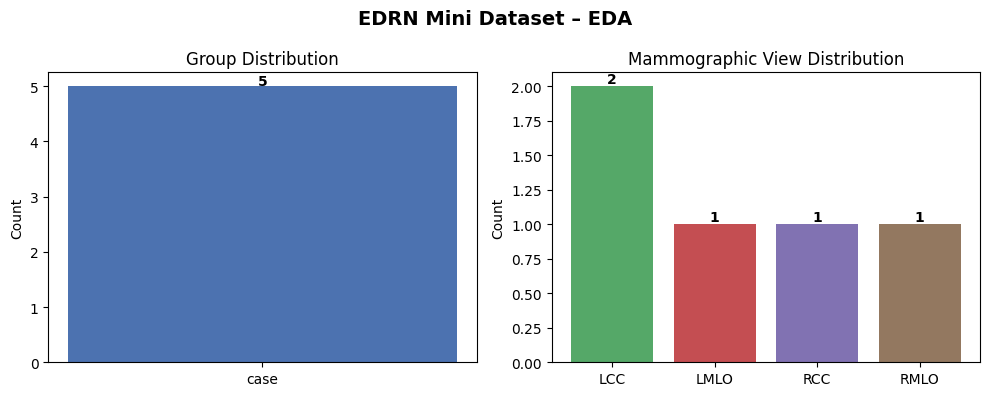

EDA plot saved to outputs/eda_distribution.png


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("EDRN Mini Dataset – EDA", fontsize=14, fontweight='bold')

# Group distribution
group_counts = df['group'].value_counts()
axes[0].bar(group_counts.index, group_counts.values, color=['#4C72B0', '#DD8452'])
axes[0].set_title("Group Distribution")
axes[0].set_ylabel("Count")
for i, v in enumerate(group_counts.values):
    axes[0].text(i, v + 0.02, str(v), ha='center', fontweight='bold')

# View distribution
view_counts = df['view'].value_counts()
axes[1].bar(view_counts.index, view_counts.values, color=['#55A868', '#C44E52', '#8172B2', '#937860'])
axes[1].set_title("Mammographic View Distribution")
axes[1].set_ylabel("Count")
for i, v in enumerate(view_counts.values):
    axes[1].text(i, v + 0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/eda_distribution.png', dpi=120, bbox_inches='tight')
plt.show()
print("EDA plot saved to outputs/eda_distribution.png")

## 4. Setup authenticated DICOM download

Authenticate against LabCAS using `LABCAS_USERNAME` / `LABCAS_PASSWORD` env vars, then define a  
download helper that streams DICOM bytes from any authenticated URL.  
The `proc_url` / `mask_url` columns from the Croissant records are used **directly** — no local files needed.

In [13]:
LABCAS_BASE = "https://edrn-labcas.jpl.nasa.gov"

def _get_jwt_token() -> str:
    """Obtain a JWT token using LABCAS_USERNAME / LABCAS_PASSWORD env vars."""
    username = os.environ['LABCAS_USERNAME']
    password = os.environ['LABCAS_PASSWORD']
    resp = requests.post(
        f"{LABCAS_BASE}/data-access-api/auth",
        auth=HTTPBasicAuth(username, password),
        timeout=30,
    )
    resp.raise_for_status()
    return resp.text.strip()


# Obtain token once; stored at module level so the Dataset can refresh it.
print("Authenticating with LabCAS …")
JWT_TOKEN   = _get_jwt_token()
AUTH_HEADERS = {"Authorization": f"Bearer {JWT_TOKEN}"}
print("✓ Token obtained")


def download_dicom_bytes(url: str) -> bytes:
    """Stream a DICOM from an authenticated LabCAS URL and return raw bytes."""
    global JWT_TOKEN, AUTH_HEADERS
    resp = requests.get(url, headers=AUTH_HEADERS, timeout=120)
    if resp.status_code == 401:          # token expired – refresh once
        print("⟳ Token expired, refreshing …")
        JWT_TOKEN    = _get_jwt_token()
        AUTH_HEADERS = {"Authorization": f"Bearer {JWT_TOKEN}"}
        resp = requests.get(url, headers=AUTH_HEADERS, timeout=120)
    resp.raise_for_status()
    return resp.content


# Quick connectivity test with the first record
test_url = df['proc_url'].iloc[0]
print(f"Testing download: {test_url[:80]} …")
test_bytes = download_dicom_bytes(test_url)
print(f"✓ Received {len(test_bytes):,} bytes")

Authenticating with LabCAS …
✓ Token obtained
Testing download: https://edrn-labcas.jpl.nasa.gov/data-access-api/download?id=Automated_Quantitat …
✓ Received 27,265,684 bytes


## 5. Load & visualise DICOM files

In [14]:
def load_dicom_as_array(url: str) -> np.ndarray:
    """Download a DICOM from `url` and return a float32 array normalised to [0, 1]."""
    raw = download_dicom_bytes(url)
    ds  = pydicom.dcmread(io.BytesIO(raw))
    arr = ds.pixel_array.astype(np.float32)
    arr -= arr.min()
    if arr.max() > 0:
        arr /= arr.max()
    return arr

# Quick sanity check – download one pair
print("Loading sample PROC …")
sample_proc = load_dicom_as_array(df['proc_url'].iloc[0])
print("Loading sample MASK …")
sample_mask = load_dicom_as_array(df['mask_url'].iloc[0])

print(f"PROC shape : {sample_proc.shape}  | dtype: {sample_proc.dtype}")
print(f"MASK shape : {sample_mask.shape}  | dtype: {sample_mask.dtype}")
print(f"PROC range : [{sample_proc.min():.3f}, {sample_proc.max():.3f}]")
print(f"MASK range : [{sample_mask.min():.3f}, {sample_mask.max():.3f}]")
print(f"MASK unique values: {np.unique(sample_mask[:16, :16])}  (showing top-left corner)")

Loading sample PROC …
Loading sample MASK …
PROC shape : (4096, 3328)  | dtype: float32
MASK shape : (4096, 3328)  | dtype: float32
PROC range : [0.000, 1.000]
MASK range : [0.000, 1.000]
MASK unique values: [0.]  (showing top-left corner)


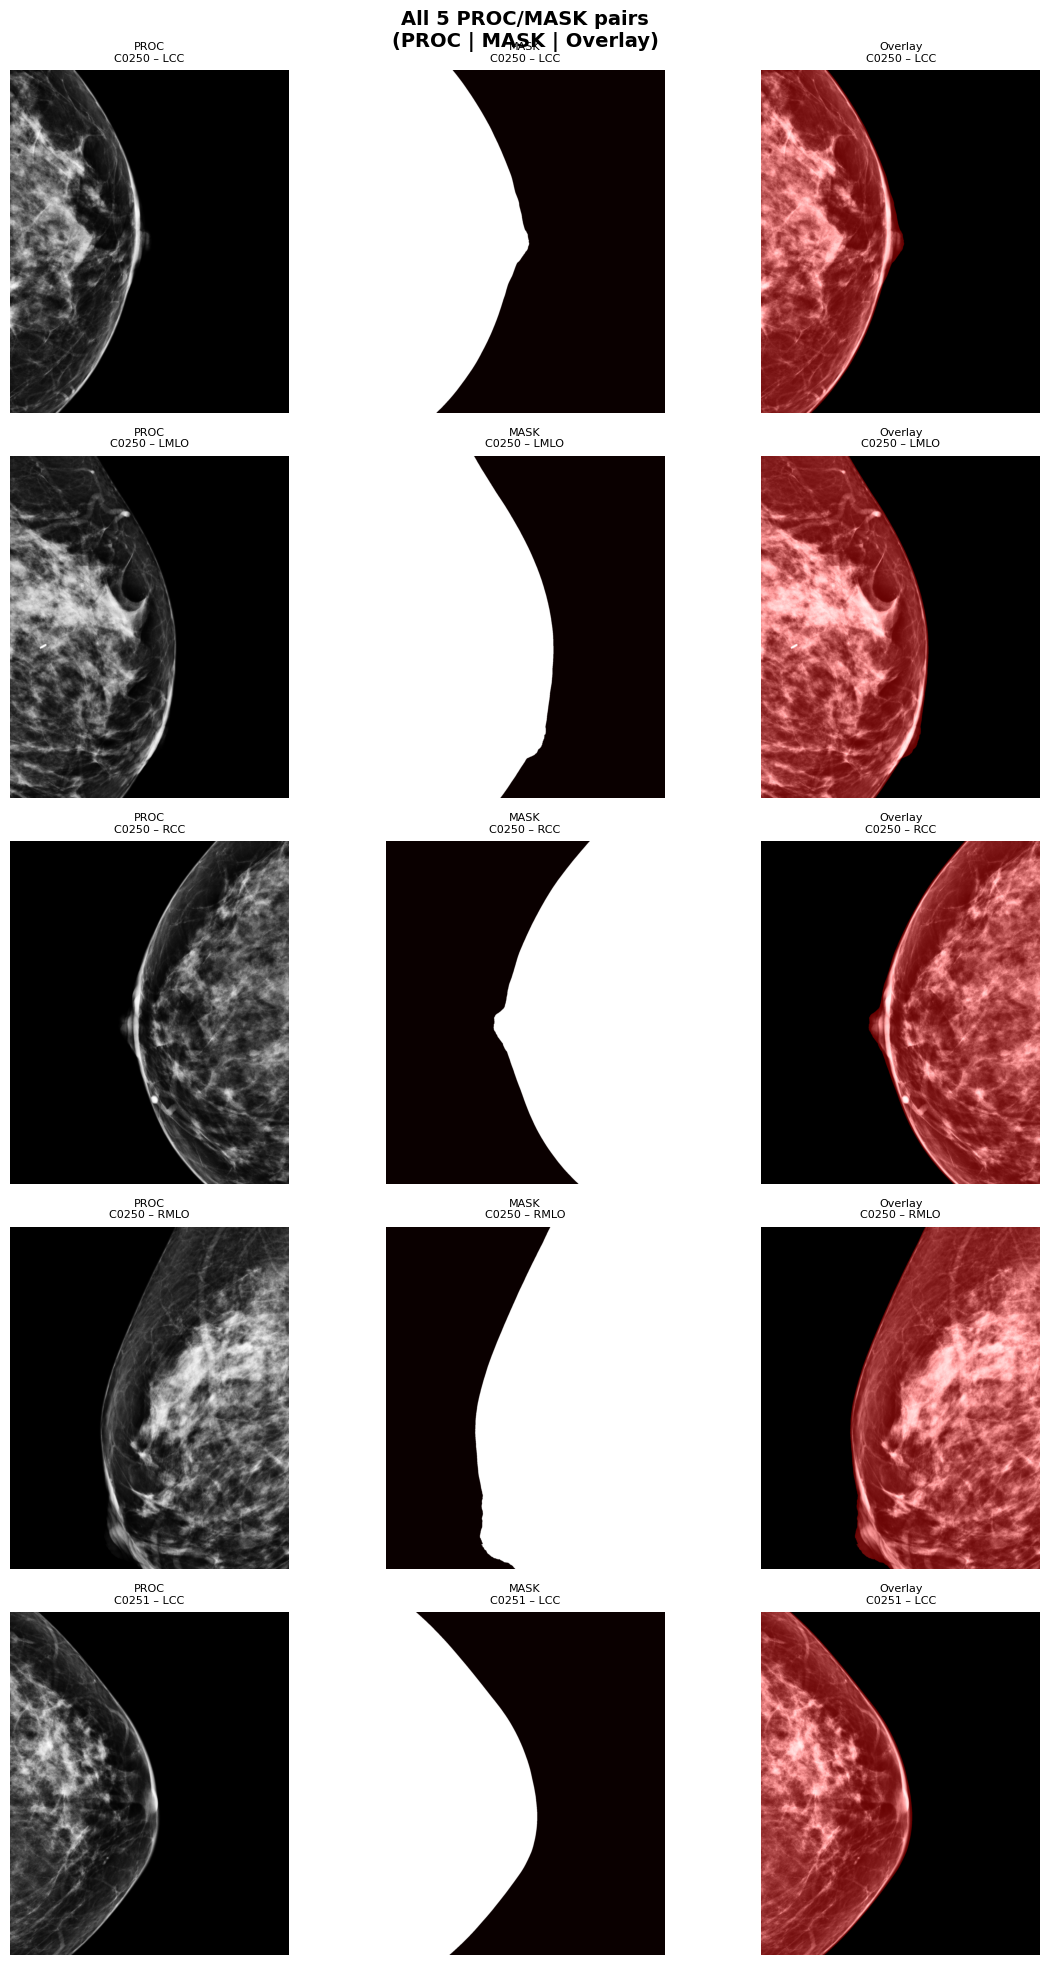

Saved to outputs/dicom_visualisation.png


In [15]:
# Visualise all 5 pairs side-by-side
fig, axes = plt.subplots(5, 3, figsize=(12, 20))
fig.suptitle("All 5 PROC/MASK pairs\n(PROC | MASK | Overlay)", fontsize=14, fontweight='bold')

for idx, row in df.iterrows():
    print(f"Downloading pair {idx+1}/5: {row['patient_id']} {row['view']} …")
    proc = load_dicom_as_array(row['proc_url'])
    mask = load_dicom_as_array(row['mask_url'])

    # Show centre crop for display
    h, w = proc.shape
    ch, cw = h // 4, w // 4
    crop_proc = proc[ch: ch + h // 2, cw: cw + w // 2]
    crop_mask = mask[ch: ch + h // 2, cw: cw + w // 2]

    label = f"{row['patient_id']} – {row['view']}"

    axes[idx, 0].imshow(crop_proc, cmap='gray')
    axes[idx, 0].set_title(f"PROC\n{label}", fontsize=8)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(crop_mask, cmap='hot')
    axes[idx, 1].set_title(f"MASK\n{label}", fontsize=8)
    axes[idx, 1].axis('off')

    # Overlay: proc as grey + mask tinted red
    overlay = np.stack([crop_proc, crop_proc, crop_proc], axis=-1)
    overlay[..., 0] = np.clip(overlay[..., 0] + 0.4 * crop_mask, 0, 1)
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(f"Overlay\n{label}", fontsize=8)
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig('outputs/dicom_visualisation.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved to outputs/dicom_visualisation.png")

## 6. PyTorch Dataset

In [16]:
IMG_SIZE = 256   # resize all images to 256×256 for uniform batching

class MammogramDataset(Dataset):
    """
    PyTorch Dataset that downloads mammogram PROC/MASK DICOM pairs on-the-fly
    from authenticated LabCAS URLs sourced directly from Croissant records.

    Each item returns:
        image  : FloatTensor (1, IMG_SIZE, IMG_SIZE)  – normalised to [0, 1]
        mask   : FloatTensor (1, IMG_SIZE, IMG_SIZE)  – binary {0, 1}
        meta   : dict with patient_id, view, group
    """

    def __init__(self, dataframe: pd.DataFrame, img_size: int = IMG_SIZE,
                 augment: bool = False):
        self.df      = dataframe.reset_index(drop=True)
        self.img_size = img_size
        self.augment  = augment

        self.resize = transforms.Resize(
            (img_size, img_size),
            interpolation=transforms.InterpolationMode.BILINEAR
        )
        self.resize_nn = transforms.Resize(
            (img_size, img_size),
            interpolation=transforms.InterpolationMode.NEAREST
        )

    def __len__(self):
        return len(self.df)

    @staticmethod
    def _load(url: str) -> np.ndarray:
        """Download DICOM from authenticated URL → normalised float32 array."""
        raw = download_dicom_bytes(url)      # uses module-level AUTH_HEADERS
        ds  = pydicom.dcmread(io.BytesIO(raw))
        arr = ds.pixel_array.astype(np.float32)
        arr -= arr.min()
        if arr.max() > 0:
            arr /= arr.max()
        return arr

    def __getitem__(self, idx: int):
        row  = self.df.iloc[idx]
        proc = self._load(row['proc_url'])
        mask = self._load(row['mask_url'])

        proc_t = torch.from_numpy(proc).unsqueeze(0)   # (1, H, W)
        mask_t = torch.from_numpy(mask).unsqueeze(0)

        proc_t = self.resize(proc_t)
        mask_t = self.resize_nn(mask_t)

        # Binarise mask
        mask_t = (mask_t > 0.5).float()

        # Simple augmentation (horizontal flip)
        if self.augment and torch.rand(1).item() > 0.5:
            proc_t = torch.flip(proc_t, dims=[-1])
            mask_t = torch.flip(mask_t, dims=[-1])

        meta = {
            'patient_id': row['patient_id'],
            'view'      : row['view'],
            'group'     : row['group'],
        }
        return proc_t, mask_t, meta


# Quick test (downloads one pair)
full_ds = MammogramDataset(df)
img, msk, meta = full_ds[0]
print(f"img  shape : {img.shape}, range [{img.min():.2f}, {img.max():.2f}]")
print(f"mask shape : {msk.shape}, unique: {msk.unique().tolist()}")
print(f"meta       : {meta}")

img  shape : torch.Size([1, 256, 256]), range [0.00, 0.96]
mask shape : torch.Size([1, 256, 256]), unique: [0.0, 1.0]
meta       : {'patient_id': 'C0250', 'view': 'LCC', 'group': 'case'}


## 7. Train / Val / Test Split (3 / 1 / 1)

In [17]:
indices = list(range(len(df)))

train_idx, temp_idx = train_test_split(indices, test_size=2, random_state=42)
val_idx, test_idx   = train_test_split(temp_idx, test_size=1, random_state=42)

print(f"Train : {train_idx}  ({len(train_idx)} samples)")
print(f"Val   : {val_idx}   ({len(val_idx)} sample)")
print(f"Test  : {test_idx}   ({len(test_idx)} sample)")

train_df = df.iloc[train_idx].copy()
val_df   = df.iloc[val_idx].copy()
test_df  = df.iloc[test_idx].copy()

train_ds = MammogramDataset(train_df, augment=True)
val_ds   = MammogramDataset(val_df)
test_ds  = MammogramDataset(test_df)

# batch_size=1
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=0)

print(f"\nDataLoaders ready  |  train={len(train_loader)}  val={len(val_loader)}  test={len(test_loader)}")

Train : [2, 0, 3]  (3 samples)
Val   : [1]   (1 sample)
Test  : [4]   (1 sample)

DataLoaders ready  |  train=3  val=1  test=1


## 8. U-Net Architecture

In [18]:
# ── building blocks ────────────────────────────────────────────────────────

class ConvBlock(nn.Module):
    """Two 3×3 convolutions + BatchNorm + ReLU."""
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class EncoderBlock(nn.Module):
    """ConvBlock → MaxPool. Returns skip feature and pooled output."""
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        return skip, self.pool(skip)


class DecoderBlock(nn.Module):
    """Upsample → concat skip → ConvBlock."""
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)   # in_ch = out_ch(up) + out_ch(skip)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


# ── U-Net ──────────────────────────────────────────────────────────────────

class SimpleUNet(nn.Module):
    """
    Lightweight U-Net for single-channel image segmentation.

    Encoder  : 1 → 16 → 32 → 64
    Bottleneck: 64 → 128
    Decoder  : 128 → 64 → 32 → 16 → 1 (sigmoid)
    """
    def __init__(self):
        super().__init__()
        self.enc1       = EncoderBlock(1,   16)
        self.enc2       = EncoderBlock(16,  32)
        self.enc3       = EncoderBlock(32,  64)
        self.bottleneck = ConvBlock(64, 128)
        self.dec3       = DecoderBlock(128, 64)
        self.dec2       = DecoderBlock(64,  32)
        self.dec1       = DecoderBlock(32,  16)
        self.out        = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        x     = self.bottleneck(x)
        x     = self.dec3(x, s3)
        x     = self.dec2(x, s2)
        x     = self.dec1(x, s1)
        return torch.sigmoid(self.out(x))


model = SimpleUNet().to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters   : {total_params:,}")
print(f"Trainable params   : {train_params:,}")

dummy = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE)
out   = model(dummy)
print(f"Input shape  : {dummy.shape}")
print(f"Output shape : {out.shape}")

Total parameters   : 482,449
Trainable params   : 482,449
Input shape  : torch.Size([1, 1, 256, 256])
Output shape : torch.Size([1, 1, 256, 256])


## 9. Loss function & optimizer

In [20]:
def dice_loss(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1.0) -> torch.Tensor:
    """
    Soft Dice loss for binary segmentation.
    pred   : (B, 1, H, W) sigmoid output in [0, 1]
    target : (B, 1, H, W) binary ground truth
    """
    pred   = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)


def combined_loss(pred: torch.Tensor, target: torch.Tensor,
                  dice_w: float = 0.5, bce_w: float = 0.5) -> torch.Tensor:
    """Weighted Dice + BCE."""
    bce  = F.binary_cross_entropy(pred, target)
    dice = dice_loss(pred, target)
    return dice_w * dice + bce_w * bce


def dice_score(pred: torch.Tensor, target: torch.Tensor,
               threshold: float = 0.5) -> float:
    """Binary Dice coefficient."""
    pred_bin = (pred > threshold).float()
    p = pred_bin.view(-1)
    t = target.view(-1)
    intersection = (p * t).sum().item()
    return (2 * intersection + 1) / (p.sum().item() + t.sum().item() + 1)


EPOCHS = 20
LR     = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Loss : Dice (0.5) + BCE (0.5)")
print(f"Optim: Adam  LR={LR}")
print(f"Epochs: {EPOCHS}")

Loss : Dice (0.5) + BCE (0.5)
Optim: Adam  LR=0.001
Epochs: 20


## 10. Training loop

In [21]:
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

best_val_loss   = float('inf')
best_model_path = Path('outputs/best_unet.pth')

for epoch in range(1, EPOCHS + 1):
    # ── TRAIN ─────────────────────────────────────────────────────────────
    model.train()
    train_loss_sum, train_dice_sum = 0.0, 0.0

    for imgs, masks, _ in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        preds = model(imgs)
        loss  = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        train_dice_sum += dice_score(preds.detach(), masks)

    n_train   = len(train_loader)
    avg_tloss = train_loss_sum / n_train
    avg_tdice = train_dice_sum / n_train

    # ── VALIDATE ──────────────────────────────────────────────────────────
    model.eval()
    val_loss_sum, val_dice_sum = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks, _ in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            loss  = combined_loss(preds, masks)
            val_loss_sum += loss.item()
            val_dice_sum += dice_score(preds, masks)

    n_val     = len(val_loader)
    avg_vloss = val_loss_sum / n_val
    avg_vdice = val_dice_sum / n_val

    scheduler.step(avg_vloss)

    history['train_loss'].append(avg_tloss)
    history['val_loss'].append(avg_vloss)
    history['train_dice'].append(avg_tdice)
    history['val_dice'].append(avg_vdice)

    if avg_vloss < best_val_loss:
        best_val_loss = avg_vloss
        torch.save(model.state_dict(), best_model_path)
        saved = '  ✓ saved'
    else:
        saved = ''

    print(f"Epoch {epoch:02d}/{EPOCHS}  "
          f"| Train Loss: {avg_tloss:.4f}  Dice: {avg_tdice:.4f}  "
          f"| Val Loss: {avg_vloss:.4f}  Dice: {avg_vdice:.4f}{saved}")

print(f"\nTraining complete. Best val loss: {best_val_loss:.4f}")
print(f"Best model → {best_model_path}")

Epoch 01/20  | Train Loss: 0.6595  Dice: 0.3962  | Val Loss: 0.6309  Dice: 0.5556  ✓ saved
Epoch 02/20  | Train Loss: 0.5544  Dice: 0.7414  | Val Loss: 0.6289  Dice: 0.5556  ✓ saved
Epoch 03/20  | Train Loss: 0.4959  Dice: 0.9228  | Val Loss: 0.6239  Dice: 0.5556  ✓ saved
Epoch 04/20  | Train Loss: 0.4433  Dice: 0.9767  | Val Loss: 0.6165  Dice: 0.5556  ✓ saved


KeyboardInterrupt: 

## 11. Results & metrics plots

In [ ]:
epochs_range = range(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('U-Net Training Results', fontsize=14, fontweight='bold')

axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', linewidth=2, markersize=4)
axes[0].plot(epochs_range, history['val_loss'],   'r-s', label='Val',   linewidth=2, markersize=4)
axes[0].set_title('Dice+BCE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_dice'], 'b-o', label='Train', linewidth=2, markersize=4)
axes[1].plot(epochs_range, history['val_dice'],   'r-s', label='Val',   linewidth=2, markersize=4)
axes[1].set_title('Dice Coefficient')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/training_curves.png', dpi=120, bbox_inches='tight')
plt.show()
print("Saved to outputs/training_curves.png")

## 12. Test-set evaluation & qualitative results

In [23]:
# Load the best checkpoint
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

test_dice_list, test_loss_list = [], []
all_imgs, all_masks, all_preds, all_metas = [], [], [], []

with torch.no_grad():
    for imgs, masks, meta in test_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss  = combined_loss(preds, masks)
        test_loss_list.append(loss.item())
        test_dice_list.append(dice_score(preds, masks))
        all_imgs.append(imgs.cpu())
        all_masks.append(masks.cpu())
        all_preds.append(preds.cpu())
        all_metas.append(meta)

mean_test_loss = sum(test_loss_list) / len(test_loss_list)
mean_test_dice = sum(test_dice_list) / len(test_dice_list)

print("=" * 45)
print("         TEST SET RESULTS")
print("=" * 45)
print(f"  Loss        : {mean_test_loss:.4f}")
print(f"  Dice score  : {mean_test_dice:.4f}")
print("=" * 45)

         TEST SET RESULTS
  Loss        : 0.6720
  Dice score  : 0.4338


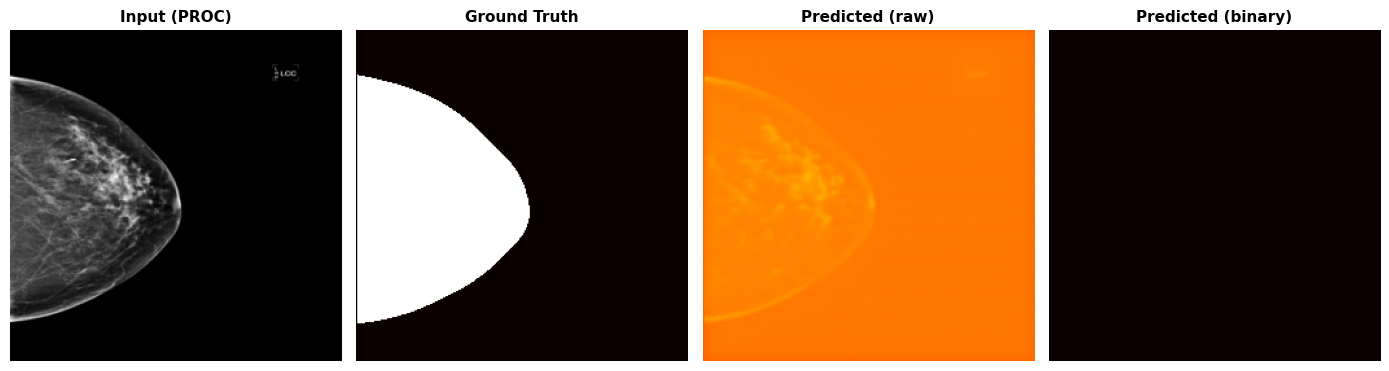

Saved to outputs/test_predictions.png


In [24]:
# Qualitative prediction visualisation
n_test = len(all_imgs)

fig, axes = plt.subplots(n_test, 4, figsize=(14, 4 * n_test))
if n_test == 1:
    axes = axes[np.newaxis, :]

col_titles = ['Input (PROC)', 'Ground Truth', 'Predicted (raw)', 'Predicted (binary)']
for c, ct in enumerate(col_titles):
    axes[0, c].set_title(ct, fontsize=11, fontweight='bold')

for i in range(n_test):
    img  = all_imgs[i][0, 0].numpy()
    mask = all_masks[i][0, 0].numpy()
    pred = all_preds[i][0, 0].numpy()
    meta = {k: v[0] if isinstance(v, list) else v for k, v in all_metas[i].items()}
    label = f"{meta['patient_id']} – {meta['view']}"

    axes[i, 0].imshow(img,  cmap='gray');                          axes[i, 0].set_ylabel(label, fontsize=8); axes[i, 0].axis('off')
    axes[i, 1].imshow(mask, cmap='hot');                           axes[i, 1].axis('off')
    axes[i, 2].imshow(pred, cmap='hot', vmin=0, vmax=1);          axes[i, 2].axis('off')
    axes[i, 3].imshow(pred > 0.5, cmap='hot');                    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('outputs/test_predictions.png', dpi=120, bbox_inches='tight')
plt.show()
print("Saved to outputs/test_predictions.png")